In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
#         print(os.path.join(dirname, filename))
        pass

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torch.utils.data import DataLoader, Dataset, random_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_recall_fscore_support
import timm
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd 

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
# input folder
from pathlib import Path
Path('/kaggle/working/oral-diseases/').mkdir(parents=True, exist_ok=True)

In [4]:
import shutil
import os

# Caries.
# The source path
caries_file_path = Path('/kaggle/input/oral-diseases/Data caries/Data caries/caries augmented data set/preview')

# The destination path
caries_new_directory = Path('/kaggle/working/oral-diseases/caries')

# Copying data from input folder to working folder
shutil.copytree(caries_file_path, caries_new_directory)

PosixPath('/kaggle/working/oral-diseases/caries')

In [5]:
# Calculus
# The source path
calculus_file_path = Path('/kaggle/input/oral-diseases/Calculus/Calculus')
# The destination path
calculus_new_directory = Path('/kaggle/working/oral-diseases/calculus')
# Copying data from input folder to working folder
shutil.copytree(calculus_file_path, calculus_new_directory)

#Gingivitis
# The source path
gingivitis_file_path = Path('/kaggle/input/oral-diseases/Gingivitis/Gingivitis')
# The destination path
gingivitis_new_directory = Path('/kaggle/working/oral-diseases/gingivitis')
# Copying data from input folder to working folder
shutil.copytree(gingivitis_file_path, gingivitis_new_directory)

#Ulcers
# The source path
ulcer_file_path = Path('/kaggle/input/oral-diseases/Mouth Ulcer/Mouth Ulcer/Mouth_Ulcer_augmented_DataSet/preview')
# The destination path
ulcer_new_directory = Path('/kaggle/working/oral-diseases/ulcers')
# Copying data from input folder to working folder
shutil.copytree(ulcer_file_path, ulcer_new_directory)

#Tooth Discoloration
# The source path
toothDiscoloration_file_path = Path('/kaggle/input/oral-diseases/Tooth Discoloration/Tooth Discoloration /Tooth_discoloration_augmented_dataser/preview')
# The destination path
toothDiscoloration_new_directory = Path('/kaggle/working/oral-diseases/toothDiscoloration')
# Copying data from input folder to working folder
shutil.copytree(toothDiscoloration_file_path, toothDiscoloration_new_directory)

#hypodontia
# The source path
hypodontia_file_path = Path('/kaggle/input/oral-diseases/hypodontia/hypodontia')
# The destination path
hypodontia_new_directory = Path('/kaggle/working/oral-diseases/hypodontia')
# Copying data from input folder to working folder
shutil.copytree(hypodontia_file_path, hypodontia_new_directory)

PosixPath('/kaggle/working/oral-diseases/hypodontia')

In [6]:
# The different classes we have from the folders
import os
build_dir = "/kaggle/working/oral-diseases"
caries_dir = os.path.join(build_dir,'caries')
gingivitis_dir = os.path.join(build_dir,'gingivitis')
toothDiscoloration_dir = os.path.join(build_dir,'toothDiscoloration')
ulcers_dir = os.path.join(build_dir,'ulcers')
hypodontia_dir = os.path.join(build_dir,'hypodontia')
calculus_dir = os.path.join(build_dir,'calculus')
os.listdir(build_dir)

['calculus',
 'caries',
 'ulcers',
 'gingivitis',
 'toothDiscoloration',
 'hypodontia']

In [7]:
# Showing the total number of images from each class/folder
import pandas as pd

data = pd.DataFrame(data=[len(os.listdir(caries_dir)), len(os.listdir(gingivitis_dir)),
                   len(os.listdir(toothDiscoloration_dir)), len(os.listdir(ulcers_dir)),
                   len(os.listdir(hypodontia_dir)),
                   len(os.listdir(calculus_dir))], index=['Caries', 'Gingivitis',
                                                                    'toothDiscoloration', 'ulcers',
                                                                    'hypodontia', 'calculus'],
              columns=['Total Images'])

In [8]:
data.to_csv('data_distribution.csv')

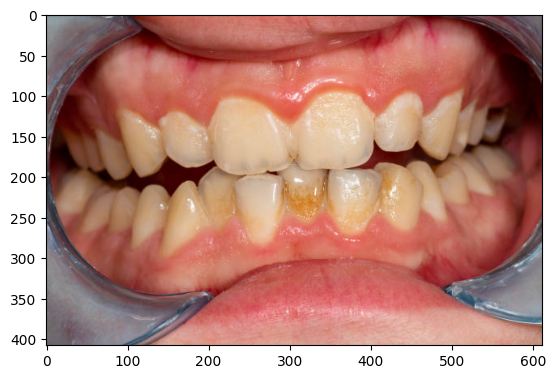

In [9]:
# Sample of caries
from PIL import Image
import matplotlib.pyplot as plt
cariesimg=Image.open("/kaggle/working/oral-diseases/calculus/(10).jpg")
plt.imshow(cariesimg)

In [10]:
categories = data.index
categories

values = data['Total Images']

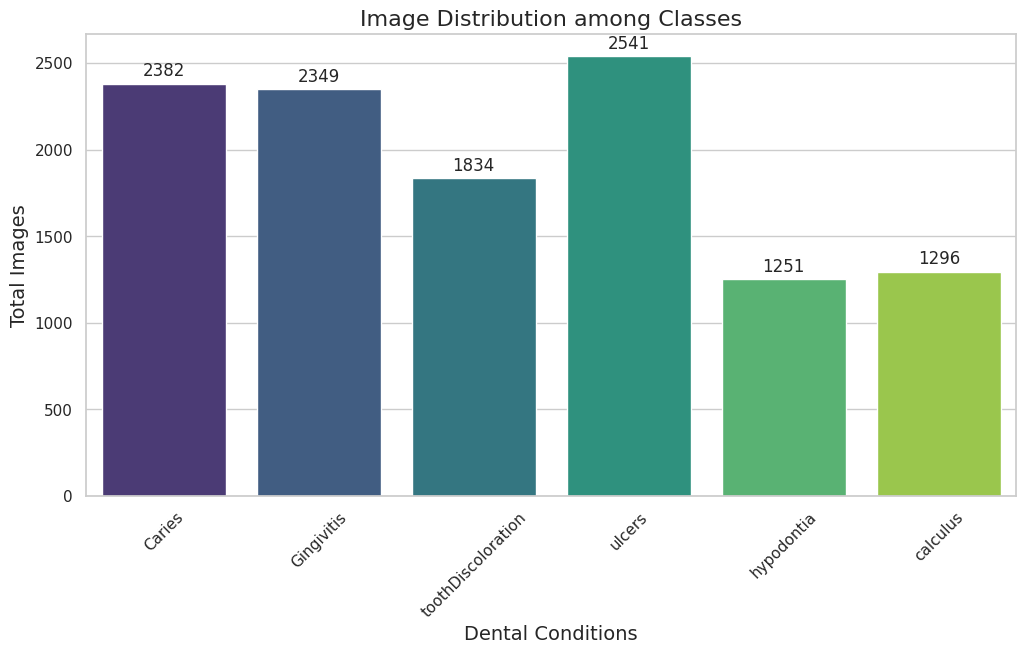

In [11]:
import seaborn as sns

# Improved 2D bar plot
plt.figure(figsize=(12, 6))
sns.set(style="whitegrid")

# Creating the barplot
barplot = sns.barplot(x=categories, y=values, palette="viridis")

# Adding the text on the top of each bar
for p in barplot.patches:
    barplot.annotate(format(p.get_height(), '.0f'), 
                     (p.get_x() + p.get_width() / 2., p.get_height()), 
                     ha = 'center', va = 'center', 
                     xytext = (0, 9), 
                     textcoords = 'offset points')

# Setting titles and labels
plt.xlabel("Dental Conditions", fontsize=14)
plt.ylabel("Total Images", fontsize=14)
plt.title("Image Distribution among Classes", fontsize=16)
plt.xticks(rotation=45)
plt.savefig('imageDistribution.png')
plt.show()

In [12]:
# Custom Dataset class
class OralDiseaseDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = os.listdir(root_dir)
        self.data = []
        for cls in self.classes:
            path = os.path.join(root_dir, cls)
            for img_name in os.listdir(path):
                self.data.append((os.path.join(path, img_name), self.classes.index(cls)))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path, label = self.data[idx]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, label

In [13]:
# InceptionResNetV2 Model
class InceptionResNetV2(nn.Module):
    def __init__(self, num_classes):
        super(InceptionResNetV2, self).__init__()
        self.model = timm.create_model('inception_resnet_v2', pretrained=True)
        in_features = self.model.classif.in_features  # Get the number of features in last layer
        self.model.classif = nn.Linear(in_features, num_classes)  # Replace last layer

    def forward(self, x):
        return self.model(x)

In [14]:
# EarlyStopping class
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss, model):
        if self.best_loss is None:
            self.best_loss = val_loss
            self.save_checkpoint(val_loss, model)
        elif val_loss > self.best_loss + self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        ''' Save model when validation loss decrease. '''
        torch.save(model.state_dict(), 'checkpoint.pt')

In [15]:
# Parameters
num_classes = 6  # Update with the number of classes
batch_size = 32
num_epochs = 100
learning_rate = 0.001
root_dir = "/kaggle/working/oral-diseases"

In [16]:
# Model, Loss and Optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = InceptionResNetV2(num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Learning Rate Scheduler
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# Early Stopping
early_stopper = EarlyStopping(patience=5)

model.safetensors:   0%|          | 0.00/224M [00:00<?, ?B/s]

In [17]:
device

device(type='cuda')

In [18]:
# Data augmentation and normalization for training
train_transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize((299, 299)),  # Inception models expect 299x299 inputs
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Normalization for testing
test_transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize((299, 299)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Initialize dataset
dataset = OralDiseaseDataset(root_dir, transform=train_transforms)

# Splitting the dataset into train and test
train_size = int(0.9 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
test_dataset.dataset.transform = test_transforms

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [19]:
# Training and Validation Loop
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

for epoch in range(num_epochs):
    # Training Phase
    model.train()
    train_loss, train_correct, train_total = 0, 0, 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        train_correct += (predicted == labels).sum().item()
        train_total += labels.size(0)

    train_accuracy = train_correct / train_total
    train_losses.append(train_loss / len(train_loader))
    train_accuracies.append(train_accuracy)

    # Validation Phase
    model.eval()
    val_loss, val_correct, val_total = 0, 0, 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            val_correct += (predicted == labels).sum().item()
            val_total += labels.size(0)

    val_accuracy = val_correct / val_total
    val_losses.append(val_loss / len(test_loader))
    val_accuracies.append(val_accuracy)

    print(f'Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_accuracy:.4f}, Val Loss: {val_losses[-1]:.4f}, Val Acc: {val_accuracy:.4f}')

    scheduler.step()

    early_stopper(val_losses[-1], model)
    if early_stopper.early_stop:
        print("Early stopping triggered")
        break

Epoch 1/100, Train Loss: 0.4874, Train Acc: 0.7985, Val Loss: 0.3899, Val Acc: 0.8405
Epoch 2/100, Train Loss: 0.2979, Train Acc: 0.8765, Val Loss: 0.2491, Val Acc: 0.8979
Epoch 3/100, Train Loss: 0.2427, Train Acc: 0.8984, Val Loss: 0.2649, Val Acc: 0.8714
Epoch 4/100, Train Loss: 0.2069, Train Acc: 0.9115, Val Loss: 0.2559, Val Acc: 0.9065
Epoch 5/100, Train Loss: 0.1971, Train Acc: 0.9148, Val Loss: 0.3082, Val Acc: 0.8877
Epoch 6/100, Train Loss: 0.1634, Train Acc: 0.9265, Val Loss: 0.2423, Val Acc: 0.9022
Epoch 7/100, Train Loss: 0.1741, Train Acc: 0.9248, Val Loss: 0.2164, Val Acc: 0.9031
Epoch 8/100, Train Loss: 0.1245, Train Acc: 0.9425, Val Loss: 0.1562, Val Acc: 0.9280
Epoch 9/100, Train Loss: 0.1033, Train Acc: 0.9511, Val Loss: 0.1577, Val Acc: 0.9211
Epoch 10/100, Train Loss: 0.0989, Train Acc: 0.9497, Val Loss: 0.1513, Val Acc: 0.9254
Epoch 11/100, Train Loss: 0.0967, Train Acc: 0.9491, Val Loss: 0.1534, Val Acc: 0.9262
Epoch 12/100, Train Loss: 0.0950, Train Acc: 0.9493,

In [20]:
# Load the best model
model.load_state_dict(torch.load('checkpoint.pt'))

<All keys matched successfully>

                    precision    recall  f1-score   support

          calculus       0.63      0.76      0.69       117
            caries       1.00      0.99      0.99       256
            ulcers       0.99      1.00      0.99       258
        gingivitis       0.87      0.79      0.83       243
toothDiscoloration       0.99      0.99      0.99       169
        hypodontia       0.98      0.99      0.99       123

          accuracy                           0.93      1166
         macro avg       0.91      0.92      0.91      1166
      weighted avg       0.93      0.93      0.93      1166



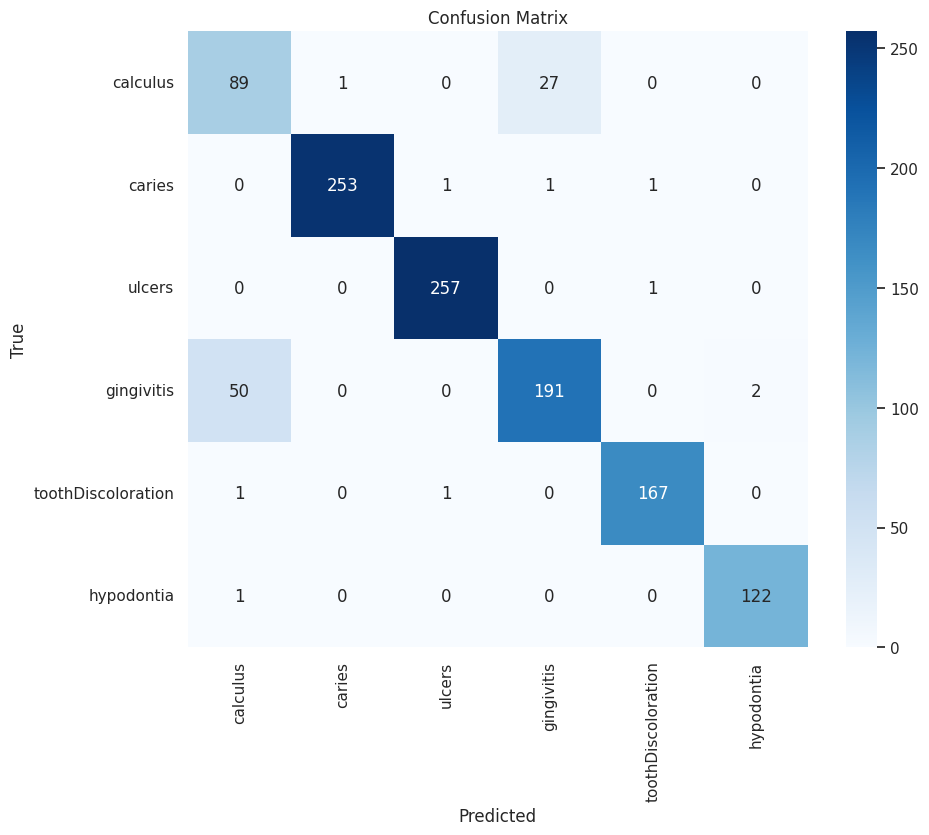

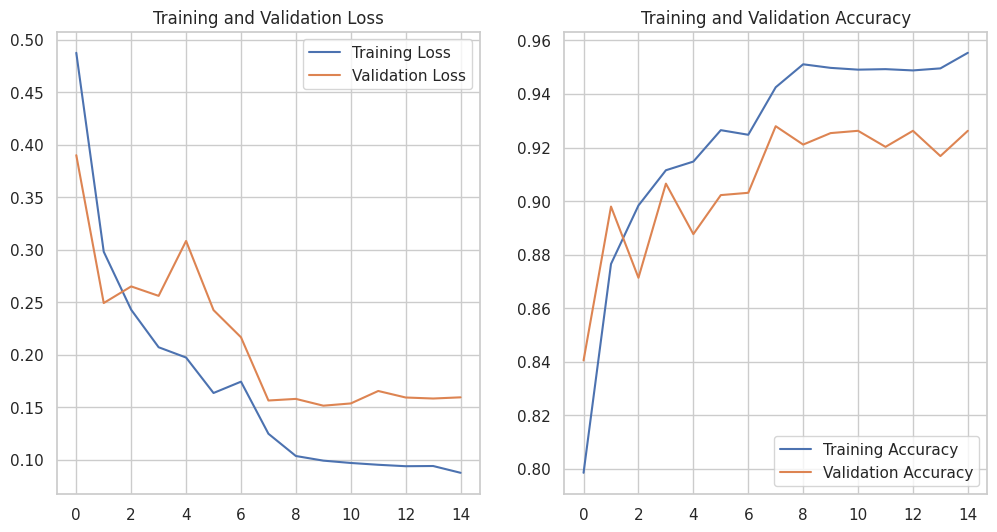

In [21]:
# Evaluation
model.eval()
y_true, y_pred = [], []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

# Metrics
accuracy = accuracy_score(y_true, y_pred)
precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')

# Classification Report
report = classification_report(y_true, y_pred, target_names=train_dataset.dataset.classes)
print(report)

# Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', xticklabels=train_dataset.dataset.classes, yticklabels=train_dataset.dataset.classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.savefig('confusion_matrix.png')
plt.show()

# Accuracy and Loss Graphs
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.savefig('accuracy_loss_graph.png')
plt.show()

# Save Metrics to CSV
metrics_data = {
    'Model': 'InceptionResnetV2',
    'Accuracy': accuracy,
    'Precision': precision,
    'Recall': recall,
    'F1 Score': f1,
    'Loss': val_losses[-1]
}
metrics_df = pd.DataFrame([metrics_data])
metrics_df.to_csv('model_performance_metrics.csv', index=False)

In [22]:
# Save the model
torch.save(model.state_dict(), 'crossVIT_transformer_oral_disease_classifier.pth')